In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hi").content

import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

workflow=StateGraph(State)
workflow.add_node("chatbot",chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# From here tool started

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
tool=TavilySearchResults(max_results=3)

In [3]:
tool.invoke("what is a langgraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner.'},
 {'url': 'https://www.langchain.com/langgraph',
  'content': 'LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Cloud is a service for deploying and scaling LangGraph applications, with a built-in Studio for prototyping, debugging, and sharing LangGraph applications.'},
 {'url': 'https://m.youtube.com/watch?v=nmDFSVRnr4Q',
  'content': 'LangGraph is an extension of LangChain enabling Multi-Agent conversation and cyclic chains. This video explains the basics of LangGraph and codesLangChain in'}]

In [4]:
tools=[tool]

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hi").content

c:\Users\sunny\langgraph-end-to-end\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Hello! How can I assist you today?'

In [7]:
llm_with_tools = llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [15]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [22]:
chatbot({"messages":["hi"]})

{'messages': [AIMessage(content='Hello, how can I assist you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-60d2b610-b6a6-4c8c-b740-1ba49a46bd8b-0', usage_metadata={'input_tokens': 75, 'output_tokens': 9, 'total_tokens': 84})]}

In [21]:
chatbot({"messages":["who is indian prime minister"]})

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavilly_search_results_json', 'arguments': '{"query": "who is the prime minister of india"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-f99f8485-386e-4eec-9bdd-62b739f15eac-0', tool_calls=[{'name': 'tavilly_search_results_json', 'args': {'query': 'who is the prime minister of india'}, 'id': '7df99704-86f8-490d-9b85-ee1b9728d130', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 27, 'total_tokens': 106})]}

In [40]:
workflow2= StateGraph(State)

In [41]:
workflow2.add_node("chatbot",chatbot)

In [42]:
import json
from langchain_core.messages import ToolMessage
class BasicToolNode:
    
    def __init__(self, tools: list)-> None:
        self.tools_by_name={tool.name: tool for tool in tools}
        
    def __call__(self, input: dict):
        if messages := input.get("messages",[]):
            message=messages[-1]
        else:
            raise ValueError("No message found in input")
        
        outputs=[]
        for tool_call in message.tool_calls:
            tool_result=self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"],
            )
            
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call['id']
                )
            )
        return {"messages":outputs}
    

In [43]:
tool_node=BasicToolNode(tools=[tool])

In [44]:
workflow2.add_node("tools",tool_node)

In [45]:
def route_tools(
    state: State
):
    if isinstance(state, list):
        ai_message=state[-1]
    elif message := state.get("messages",[]):
        ai_message=message[-1]
        
    else:
        raise ValueError(f"no message found in the input state to tool egde: {state}")
    
    if hasattr(ai_message,"tool_calls") and len(ai_message.tool_calls)>0:
        return "tools"
    
    return END


In [48]:
workflow2.add_edge(START, "chatbot")

In [46]:
workflow2.add_conditional_edges(
    "chatbot",

    route_tools,
    
    {"tools":"tools", 
     END:END}
)

In [49]:
app2=workflow2.compile()

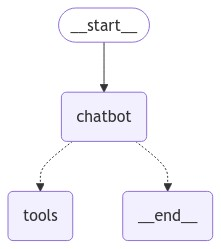

In [52]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [53]:
def stream_graph_output(user_input: str):
    for event in app2.stream({"messages":[("user",user_input)]}):
        for key,value in event.items():
            print(f"Coming from {key} node")
            print("="*24)
            print("Assistant:", value["messages"][-1].content)

In [54]:
while True:
    try:
        user_input=input("User: ")
        if user_input.lower() in ["quit","exit","q"]:
            print("Goodbye")
            break
        
        stream_graph_output(user_input)
    except:
        # fallback if input is not available
        user_input="what do you know about LangGraph?"
        print("User:" + user_input)
        stream_graph_output(user_input)
        break

Coming from chatbot node
Assistant: 
User:what do you know about LangGraph?
Coming from chatbot node
Assistant: 


KeyError: 'tavilly_search_results_json'

In [92]:
workflow2.add_edge("tools","chatbot")

app2=workflow2.compile()

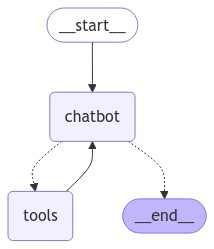

In [93]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [94]:
def stream_graph_output(user_input: str):
    for event in app2.stream({"messages":[("user",user_input)]}):
        for key,value in event.items():
            print(f"Coming from {key} node")
            print("="*24)
            print("Assistant:", value["messages"][-1].content)
        

In [95]:
while True:
    try:
        user_input=input("User: ")
        if user_input.lower() in ["quit","exit","q"]:
            print("Goodbye")
            break
        
        stream_graph_output(user_input)
    except:
        # fallback if input is not available
        user_input="what do you know about LangGraph?"
        print("User:" + user_input)
        stream_graph_output(user_input)
        break

Coming from chatbot node
Assistant: 
User:what do you know about LangGraph?
Coming from chatbot node
Assistant: 


KeyError: 'tavilly_search_results_json'

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hi").content

c:\Users\sunny\langgraph-end-to-end\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Hello! How can I help you today?'

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [12]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [13]:
graph_builder.add_edge(START, "chatbot")

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [15]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [16]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [17]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

In [18]:
graph = graph_builder.compile()

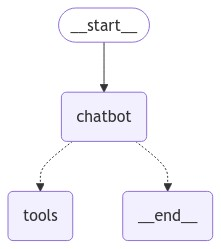

In [20]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
graph.invoke({"messages":["who is a current president of USA?"]})

{'messages': [HumanMessage(content='who is a current president of USA?', additional_kwargs={}, response_metadata={}, id='0fed674d-5253-4d58-ab4a-d8671882de8d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current president of USA"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-7f686cbf-fd7f-45dc-bf38-bdf61f507241-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current president of USA'}, 'id': '34e1c935-374d-480c-845c-463da3ca

In [22]:
graph.invoke({"messages":["hi"]})

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='8384dfb0-c1bc-447a-a3c5-3f05ef9e9499'),
  AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b508f413-49cc-4eed-9e18-28dcf6078f57-0', usage_metadata={'input_tokens': 75, 'output_tokens': 10, 'total_tokens': 85})]}